# Instructions 

1. Install tensorflow - "pip install tensorflow"   
- Install Keras - "pip install keras"
- Install scipy, numpy and scikit-learn libraries via pip. 


In [1]:
# necessary libraries 
import pickle
import numpy as np
% matplotlib inline
import matplotlib.pyplot as plt
import random
import time


In [2]:
# file load helpers 
_totalBatch = 5
_IMAGE_NORMALISED = False

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def loadTrainigBatch(filepath):
    rawRGBFeatures = None
    trainingLabels = None
    
    for i in range(_totalBatch):
        # load all 5 batches and join the raw RGB data and indexes by row (vstack/hstack)? 
        #print(i+1)
        #print(batch1.keys())
        #print(labelMeta.keys())
        batch = unpickle(filepath + str(i + 1)) # load batch
        if i == 0: 
            rawRGBFeatures = batch.get(b"data")
            trainingLabels = batch.get(b"labels")
        else:
            rawRGBFeatures = np.vstack((rawRGBFeatures,batch.get(b"data")))
            trainingLabels = np.hstack((trainingLabels,batch.get(b"labels")))
    
    return rawRGBFeatures, trainingLabels

# image display helpers 
def printRandom10Images(rawData):    
    allImages = np.rot90(np.reshape(rawRGBFeatures, (50000,32,32,3), order='F'), axes=(2,1))
    print("raw image dimensions:", allImages.shape)
    # plot the first 10 random images to verify the conversion
    fig = plt.figure(figsize=(6,3))
    counter = 0
    random.seed(5)
    for i in random.sample(range(1, 50000), 10):
        ax = fig.add_subplot(2, 5, 1 + counter, xticks=[], yticks=[])
        im = allImages[i,:,:,:] 
        ax.set_title(text_labels[trainingLabels[i]])
        plt.imshow(im)
        counter += 1
    plt.show()
    


In [3]:
# file loads - raw data + numerical labels + text labels

rawRGBFeatures, trainingLabels = loadTrainigBatch("data/cifar-10-batches-py/data_batch_")
labelMeta = unpickle("data/cifar-10-batches-py/batches.meta") # load the label metadata
text_labels = [x.decode("utf-8") for x in labelMeta.get(b"label_names")] # to convert from byte literal to string

print(rawRGBFeatures.shape)
print(trainingLabels.shape)

# extraction unique labels 
labels = np.unique(trainingLabels)
print(labels)
print(text_labels)

(50000, 3072)
(50000,)
[0 1 2 3 4 5 6 7 8 9]
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


raw image dimensions: (50000, 32, 32, 3)


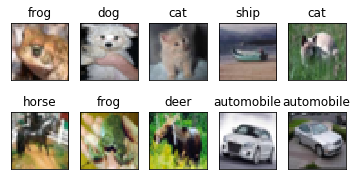

In [4]:
# print random 10 images
printRandom10Images(rawRGBFeatures)

## normalise the images (RGB) 

At times, you want to get rid of distortions caused by lights and shadows in an image. Normalizing the RGB values of an image can at times be a simple and effective way of achieving this.

When normalizing the RGB values of an image, you divide each pixel's value by the sum of the pixel's value over all channels. So if you have a pixel with intensitied R, G, and B in the respective channels... its normalized values will be R/S, G/S and B/S (where, S=R+G+B).

raw image dimensions: (50000, 32, 32, 3)


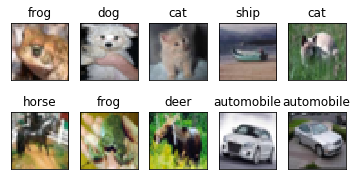

In [5]:
# normalise 
rawRGBFeatures = rawRGBFeatures.astype("float32") # convert the dataset to float32
if _IMAGE_NORMALISED == False: 
    rawRGBFeatures = rawRGBFeatures/255 # normalise by dividing by 255
    _IMAGE_NORMALISED = True
# now plot again to see verify the image quality 
printRandom10Images(rawRGBFeatures)


In [6]:
# split the data into train and test splits (80/20)

from sklearn.model_selection import train_test_split

train_data, eval_data, train_labels, eval_labels = train_test_split(rawRGBFeatures, trainingLabels, test_size=0.20, random_state=42)

train_data = train_data.astype("float32")
train_labels = train_labels.astype("float32")
eval_data = eval_data.astype("float32")
eval_labels = eval_labels.astype("float32")

print(train_data.shape)
print(train_labels.shape)
print(eval_data.shape)
print(eval_labels.shape)


(40000, 3072)
(40000,)
(10000, 3072)
(10000,)


## CNN - Tensorflow only

Let's build a model to classify the images in the cifar10 dataset using the following CNN architecture:

1. Convolutional Layer #1: Applies 32 5x5 filters (extracting 5x5-pixel subregions), with ReLU activation function
- Pooling Layer #1: Performs max pooling with a 2x2 filter and stride of 2 (which specifies that pooled regions do not overlap)
- Convolutional Layer #2: Applies 64 5x5 filters, with ReLU activation function
- Pooling Layer #2: Again, performs max pooling with a 2x2 filter and stride of 2
- Dense Layer #1: 1,024 neurons, with dropout regularization rate of 0.4 (probability of 0.4 that any given element will be dropped during training)
- Dense Layer #2 (Logits Layer): 10 neurons, one for each digit target class (0–9).

In [119]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Imports
import numpy as np
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)

# Our application logic will be added here

def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # cifar10 images are 32x32 pixels, and have 3 color channels (RGB)
    input_layer = tf.reshape(features["x"], [-1,32,32,3])
    print("shape of initial input:", input_layer.shape)

    # Convolutional Layer #1
    # Computes 32 features using a 7x7 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 32, 32, 3]
    # Output Tensor Shape: [batch_size, 32, 32, 32]
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[7, 7],
        padding="same",
        activation=tf.nn.relu)
    
    print("shape post convolution:", conv1.shape)

    # Pooling Layer #1
    # First max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 32, 32, 32]
    # Output Tensor Shape: [batch_size, 16, 16, 32]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    print("shape post conv1 pooling:", pool1.shape)

    # Convolutional Layer #2
    # Computes 64 features using a 7x7 filter.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 16, 16, 32]
    # Output Tensor Shape: [batch_size, 16, 16, 64]
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[7, 7],
        padding="same",
        activation=tf.nn.relu)
    print("shape post conv 2:", conv2.shape)
    
    # Pooling Layer #2
    # Second max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 16, 16, 64]
    # Output Tensor Shape: [batch_size, 8, 8, 64]
    
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    print("shape post pool 2:", pool2.shape)

    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 8, 8, 64]
    # Output Tensor Shape: [batch_size, 8 * 8 * 64]
    pool2_flat = tf.reshape(pool2, [-1, 8 * 8 * 64])
    
    print("shape of flattened tensor prior to a fully connected layer:", pool2_flat.shape)

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 7 * 7 * 64]
    # Output Tensor Shape: [batch_size, 1024]
    dense = tf.layers.dense(inputs=pool2_flat, units=100, activation=tf.nn.relu)

    # Add dropout operation; 0.6 probability that element will be kept
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 10]
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
    loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=logits)
    tf.summary.scalar('Cross Entropy', loss)
    
    merged = tf.summary.merge_all()
    
    #loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss,global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}

    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)



### Train and eval the CNN model 


(40000, 3072)
(40000,)
(10000, 3072)
(10000,)


In [120]:
# Create the Estimator
cifar10_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="tmp/cifar10_convnet_model")

# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
#tensors_to_log = {"probabilities": "softmax_tensor"}
#logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      batch_size=100,
      num_epochs=None,
      shuffle=True)
#cifar10_classifier.train(input_fn=train_input_fn,steps=20000,hooks=[logging_hook])
cifar10_classifier.train(input_fn=train_input_fn,steps=20)



INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
shape of initial input: (100, 32, 32, 3)
shape post convolution: (100, 32, 32, 32)
shape post conv1 pooling: (100, 16, 16, 32)
shape post conv 2: (100, 16, 16, 64)
shape post pool 2: (100, 8, 8, 64)
shape of flattened tensor prior to a fully connected layer: (100, 4096)
INFO:tensorflow:Summary name Cross Entropy is illegal; using Cross_Entropy instead.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tmp/cifar10_convnet_model/model.ckpt-5040
INFO:tensorflow:Saving checkpoints for 5041 into tmp/cifar10_convnet_model/model.ckpt.
INFO:tensorflow:loss = 1.73501, step = 5041
INFO:tensorflow:Saving checkpoints for 5060 into tmp/cifar10_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 1.69209.


In [106]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = cifar10_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

shape of initial input: (?, 32, 32, 3)
shape post convolution: (?, 32, 32, 32)
shape post conv1 pooling: (?, 16, 16, 32)
shape post conv 2: (?, 16, 16, 64)
shape post pool 2: (?, 8, 8, 64)
shape of flattened tensor prior to a fully connected layer: (?, 4096)
INFO:tensorflow:Starting evaluation at 2018-05-19-13:15:25
INFO:tensorflow:Restoring parameters from tmp/cifar10_convnet_model/model.ckpt-5000
INFO:tensorflow:Finished evaluation at 2018-05-19-13:15:42
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.3935, global_step = 5000, loss = 1.70058
{'accuracy': 0.3935, 'loss': 1.7005845, 'global_step': 5000}


In [116]:
print(losses[0])

Tensor("softmax_cross_entropy_loss/value:0", shape=(), dtype=float32)


## CNN - Using Keras

In [7]:
from __future__ import print_function

import keras
import tensorflow as tf
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import os

np.random.seed(2018)
if K.backend()=='tensorflow':
    print(K.image_dim_ordering())
    
 

Using TensorFlow backend.


tf


In [8]:
# helpers 

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

# TRAINING CONSTANTS
batch_size = 32
num_classes = 10
epochs = 100
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

### Design & Training CNN model 

| Layer name | Description |
| :--- |:------------- |
| Convolution 1      | 32 features with 3x3 kernel with ReLU activation |
| Convolution 2      | 32 features with 3x3 kernel with ReLU activation |
| Max pooling 1 | max pooling with 2x2 pool size and a dropout of 0.25 to counter overfitting issues |
| Convolution 3 | 64 features with 3x3 kernel with ReLU activation |
| Convolution 4 | 64 features with 3x3 kernel with ReLU activation |
| Max pooling 2 | max pooling with 2x2 pool size and a dropout of 0.25 to counter overfitting issues |
| dense layer 1 | 512 neurons/units with ReLU activation followed by a dropout at 0.5 |
| Dense layer 2 (softmax) | 10 neurons/units (10 classes) with softmax activation to produce logits (final prediction) |


In [13]:
# prep the dataset for training and testing 
xTrain = np.rot90(np.reshape(train_data, (40000,32,32,3), order='F'), axes=(2,1))
xTest = np.rot90(np.reshape(eval_data, (10000,32,32,3), order='F'), axes=(2,1))
# convert the labels to one hot encoded values
y_train = keras.utils.to_categorical(train_labels, num_classes)
y_test = keras.utils.to_categorical(eval_labels, num_classes)


In [15]:
# CNN layers 

model = Sequential()
# layer 1 - conv 1: 32 features with 3x3 kernel with ReLU activation
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=xTrain.shape[1:])) # channel last data type by default
model.add(Activation('relu'))

# layer 2 - conv 2: 32 features with 3x3 kernel with ReLU activation
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

# layer 3 - pool 1: max pooling with 2x2 pool size and a dropout to deal with some overfitting issues
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# layer 4 - conv 3: 64 features with 3x3 kernel with ReLU activation
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

# layer 5 - conv 4: 64 features with 3x3 kernel with ReLU activation
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

# layer 6 - pool 2: max pooling with 2x2 pool size and a dropout to deal with some overfitting issues
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

# layer 7 - Dense 1: 512 neurons/units with ReLU activation followed by a dropout at 0.5
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# layer 8 - Dense 2: 10 neurons/units (for 10 classes) with softmax activation for final prediction
model.add(Dense(num_classes))
model.add(Activation('softmax'))


In [18]:
# checkpoint
#filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]
# Fit the model
#model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, callbacks=callbacks_list, verbose=0)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
start = time.time()
model_info = model.fit(xTrain, y_train, 
                       batch_size=100, epochs=50, 
                       validation_data = (xTest, y_test), 
                       verbose=2)
print("Model took %0.2f seconds to train"%(time.time() - start))

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
 - 173s - loss: 1.0082 - acc: 0.6442 - val_loss: 0.8905 - val_acc: 0.6822
Epoch 2/50
 - 174s - loss: 0.9214 - acc: 0.6753 - val_loss: 0.8258 - val_acc: 0.7148
Epoch 3/50
 - 186s - loss: 0.8584 - acc: 0.6968 - val_loss: 0.8097 - val_acc: 0.7161
Epoch 4/50
 - 177s - loss: 0.7972 - acc: 0.7206 - val_loss: 0.7559 - val_acc: 0.7382
Epoch 5/50
 - 170s - loss: 0.7516 - acc: 0.7356 - val_loss: 0.7146 - val_acc: 0.7481
Epoch 6/50
 - 170s - loss: 0.7119 - acc: 0.7504 - val_loss: 0.7013 - val_acc: 0.7537
Epoch 7/50
 - 170s - loss: 0.6780 - acc: 0.7595 - val_loss: 0.6847 - val_acc: 0.7563
Epoch 8/50
 - 171s - loss: 0.6385 - acc: 0.7751 - val_loss: 0.6938 - val_acc: 0.7654
Epoch 9/50
 - 171s - loss: 0.6255 - acc: 0.7790 - val_loss: 0.6654 - val_acc: 0.7743
Epoch 10/50
 - 171s - loss: 0.5913 - acc: 0.7911 - val_loss: 0.6579 - val_acc: 0.7742
Epoch 11/50
 - 179s - loss: 0.5766 - acc: 0.7958 - val_loss: 0.6521 - val_acc: 0.7789
Epoch 12/50
 

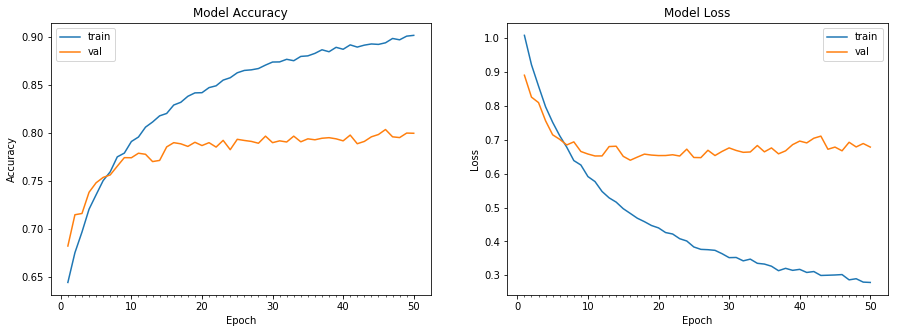

Accuracy on test data is: 79.97
Model took 13.06 seconds to predict test set


In [27]:
# plot model history
plot_model_history(model_info)
# compute test accuracy
start = time.time()
print("Accuracy on test data is: %0.2f"%accuracy(xTest, y_test, model))
print("Model took %0.2f seconds to predict test set"%(time.time() - start))

In [28]:
# save the keras model (in HDF format)
model.save("files/keras/cifar_v1.h5")

# returns a compiled model
# identical to the previous one
#from keras.models import load_model
#model2 = load_model('files/keras/cifar_v1.h5')
# Train the model
#start = time.time()
#print("Accuracy on test data is: %0.2f"%accuracy(xTest, y_test, model2))
#print("Model took %0.2f seconds to predict test set"%(time.time() - start))